 # Homework 5
 ## Group 10

## Assignment 1 - Reviews

We review the homeworks for groups 15 and 32.

## Assignment 2 - CIFAR-10 Classification

In [16]:
# the necessary imports

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import datetime as datetime
import tqdm

### 2.1 Prepare the Dataset

In [19]:
def preprocess(dataset):

    # convert data from uint8 to float32
    dataset = dataset.map(lambda img, target: (tf.cast(img, tf.float32), target))

    # flatten the images into vectors - we don't do this step for CNN, results in error when feeding to the layers
    # dataset = dataset.map(lambda img, target: (tf.reshape(img, (-1,)), target))

    # input normalization, just bringing image values from range [0, 255] to [-1, 1]
    dataset = dataset.map(lambda img, target: ((img / 128.) - 1., target))

    # create one-hot targets with depth 10 since cifar 10 has 10 classes
    dataset = dataset.map(lambda img, target: (img, tf.one_hot(target, depth=10)))

    # cache
    dataset = dataset.cache()

    # shuffle, batch, prefetch
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(2**6)
    dataset = dataset.prefetch(tf.data.AUTOTUNE) 

    # return preprocessed dataset
    return dataset

In [ ]:
(train_ds, test_ds), ds_info = tfds.load ('cifar10', split =['train', 'test'], as_supervised = True, with_info = True)

print("ds_info: \n", ds_info)

# visualize a sample of the dataset
tfds.show_examples(train_ds, ds_info)


In [21]:
train_dataset = preprocess(train_ds)
test_dataset = preprocess(test_ds)

### 2.2 Create a CNN Model

In [39]:
# straight from the lecture
class BasicConv(tf.keras.Model):
    def __init__(self):
        super(BasicConv, self).__init__()

        # input 32x32x3 with 3 as the color channels
        self.convlayer1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu') # after this: 32x32x24
        self.convlayer2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu') # 32x32x24
        self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2) # 16x16x24

        self.convlayer3 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu') # 16x16x48
        self.convlayer4 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu') # 16x16x48
        self.global_pool = tf.keras.layers.GlobalAvgPool2D() # 1x1x48

        self.out = tf.keras.layers.Dense(10, activation='softmax')

        self.loss_function = tf.keras.losses.CategoricalCrossentropy()
        self.optimizer = tf.keras.optimizers.Adam()

        self.metrics_list = [
                    tf.keras.metrics.Mean(name="loss"),
                    tf.keras.metrics.BinaryAccuracy(name="acc"), # only for subtask 0, not for subtask 1
                    ]

    @tf.function
    def call(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = self.pooling(x)
        x = self.convlayer3(x)
        x = self.convlayer4(x)
        x = self.global_pool(x)
        x = self.out(x)
        return x


    @property
    def metrics(self):
        return self.metrics_list

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()

    @tf.function
    def train_step(self, input):
        img, label = input

        with tf.GradientTape() as tape:
            prediction = self(img, training=True)
            loss = self.loss_function(label, prediction)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # update loss metric
        self.metrics[0].update_state(loss)

        # for all metrics except loss, update states (accuracy etc.)
        for metric in self.metrics[1:]:
            metric.update_state(label, prediction) # + tf.reduce_sum(self.losses)

        # Return a dictionary mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    @tf.function
    def test_step(self, input):

        img, label = input

        prediction = self(img, training=False)
        loss = self.loss_function(label, prediction) # + tf.reduce_sum(self.losses)

        # update loss metric
        self.metrics[0].update_state(loss)

        # for accuracy metrics:
        for metric in self.metrics[1:]:
            metric.update_state(label, prediction)

        # Return a dictionary mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}


In [40]:
'''
# straight from the lecture
class DenselyConnectedCNNLayer(tf.keras.layers.Layer):
  def __init__(self, num_filters):
    super(DenselyConnectedCNNLayer, self).__init__()
    self.conv = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=3, padding='same', activation='relu')

  def call(self, x):
    c = self.conv(x)
    x = tf.concat((x,c), axis=-1)
    return x

class DenselyConnectedCNNBlock(tf.keras.layers.Layer):
  def __init__(self, num_filters, layers):
    super(DenselyConnectedCNNBlock, self).__init__()
    self.layers = [DenselyConnectedCNNLayer(num_filters) for _ in range(layers)]

  def call(self, x):
    for layer in self.layers:
      x = layer(x)
    return x


class DenselyConnectedCNN(tf.keras.Model):
  def __init__(self):
    super(DenselyConnectedCNN, self).__init__()

    self.denseblock1 = DenselyConnectedCNNBlock(24,4)
    self.pooling1 = tf.keras.layers.MaxPooling2D()

    self.denseblock2 = DenselyConnectedCNNBlock(24,4)
    self.pooling2 = tf.keras.layers.MaxPooling2D()

    self.denseblock3 = DenselyConnectedCNNBlock(24,4)
    self.globalpooling = tf.keras.layers.GlobalAvgPool2D()
    self.out = tf.keras.layers.Dense(10, activation='softmax')

  def call(self,x):
    x = self.denseblock1(x)
    x = self.pooling1(x)
    x = self.denseblock2(x)
    x = self.pooling2(x)
    x = self.denseblock3(x)
    x = self.globalpooling(x)
    x = self.out(x)
    return x
'''

"\n# straight from the lecture\nclass DenselyConnectedCNNLayer(tf.keras.layers.Layer):\n  def __init__(self, num_filters):\n    super(DenselyConnectedCNNLayer, self).__init__()\n    self.conv = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=3, padding='same', activation='relu')\n\n  def call(self, x):\n    c = self.conv(x)\n    x = tf.concat((x,c), axis=-1)\n    return x\n\nclass DenselyConnectedCNNBlock(tf.keras.layers.Layer):\n  def __init__(self, num_filters, layers):\n    super(DenselyConnectedCNNBlock, self).__init__()\n    self.layers = [DenselyConnectedCNNLayer(num_filters) for _ in range(layers)]\n\n  def call(self, x):\n    for layer in self.layers:\n      x = layer(x)\n    return x\n\n\nclass DenselyConnectedCNN(tf.keras.Model):\n  def __init__(self):\n    super(DenselyConnectedCNN, self).__init__()\n\n    self.denseblock1 = DenselyConnectedCNNBlock(24,4)\n    self.pooling1 = tf.keras.layers.MaxPooling2D()\n\n    self.denseblock2 = DenselyConnectedCNNBlock(24,4)\n   

### 2.3 Training

In [41]:
# Initiate the logs and metrics
config_name= "config_name"
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

train_log_path = f"logs/{config_name}/{current_time}/train"
val_log_path = f"logs/{config_name}/{current_time}/val"

# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)

# log writer for validation metrics
val_summary_writer = tf.summary.create_file_writer(val_log_path)

# Initiate epochs and learning rate as global variables
epochs = 15
learning_rate = 0.01

# Define arrays for saving values for later visualization
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [42]:
# define the training loop

def training():

    network = BasicConv()

    # Train the model
    for epoch in range(epochs):
        print(f"Epoch: {epoch}, optimizer: {network.optimizer}")

        for data in tqdm.tqdm(train_dataset, position=0, leave=True):
            metrics = network.train_step(data)

            with train_summary_writer.as_default():
                for metric in network.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        # print the end acc and loss
        print([f"train_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # make a list of losses and accuracies
        for (key, value) in metrics.items():
            if key == "loss":
                train_losses.append(value.numpy())
            elif key == "acc":
                train_accuracies.append(value.numpy())

        # reset metrics for next round
        network.reset_metrics()

        # Testing
        for data in test_dataset:
            metrics = network.test_step(data)

            # log the accs and losses
            with val_summary_writer.as_default():
                for metric in network.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step = epoch)

        # print the end acc and loss
        print([f"val_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # make a list of losses and accuracies
        for (key, value) in metrics.items():
            if key == "loss":
                val_losses.append(value.numpy())
            elif key == "acc":
                val_accuracies.append(value.numpy())

        # reset all metrics
        network.reset_metrics()

In [ ]:
# prepare the tensorboard ahead of training

%load_ext tensorboard
%tensorboard --logdir logs/fit

In [ ]:
training()

### 2.4 - Visualization

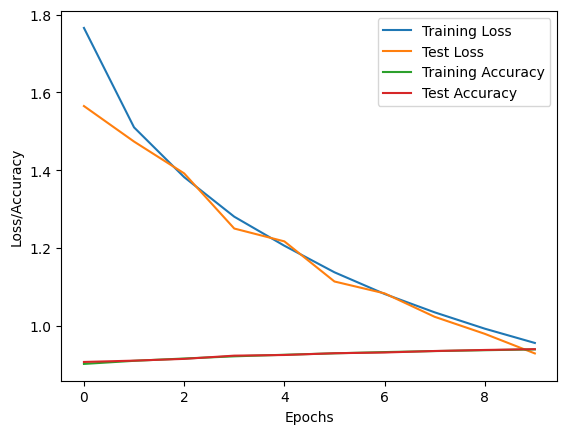

In [45]:
# visualize the results

fig = plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(val_losses)
line3, = plt.plot(train_accuracies)
line4, = plt.plot(val_accuracies)
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2,line3,line4),("Training Loss","Test Loss","Training Accuracy","Test Accuracy"))
fig.savefig("CNN Performance CIFAR-10")
plt.show()

### Assignment 3 - Playing Around

We observed the following with the following modifications to our network:

Change 1 () -

Change 2 () -

...